# Clifford Circuit Spectrum

In [44]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from kraus_channels import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *
from analysis import *
from utils import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [45]:
def resample_diluted(diluted_channel, U = None, num_samples = None):
    d = diluted_channel.d
    c = diluted_channel.c
    rank = diluted_channel.rank
    
    n = int(np.log2(d))
    spectrum_resample_list = []
    for i in tqdm(range(num_samples)):
            
        diluted_resample = DilutedKrausMap(U=U, c=c, kraus_part=KrausMap(d, rank = rank))
        spectrum_resample = channel_spectrum(diluted_resample, use_coords=True, keep_real=True)
        spectrum_resample_list.append(spectrum_resample)
    
    spectrum_resample = np.real(np.concatenate(spectrum_resample_list))
    
    return spectrum_resample

In [47]:
model1 = loader(data_path("manila_4qubit_integrable_alternative.model"))
d = model1.channel.d

np.random.seed(42)
random.seed(42)

circuit = integrable_circuit(4, 4)
U = circuit_to_matrix(circuit)

channel_unitary = ChoiMapStatic(U, mode="unitary")
channel_diluted = DilutedKrausMap(U=U, c=0.49, kraus_part=KrausMap(d, rank=10))

In [48]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample1 = resample_diluted(channel_diluted, U=U, num_samples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\krist\AppData\Local\Temp\ipykernel_6712\34604505.py:16: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001D8C28733D0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")


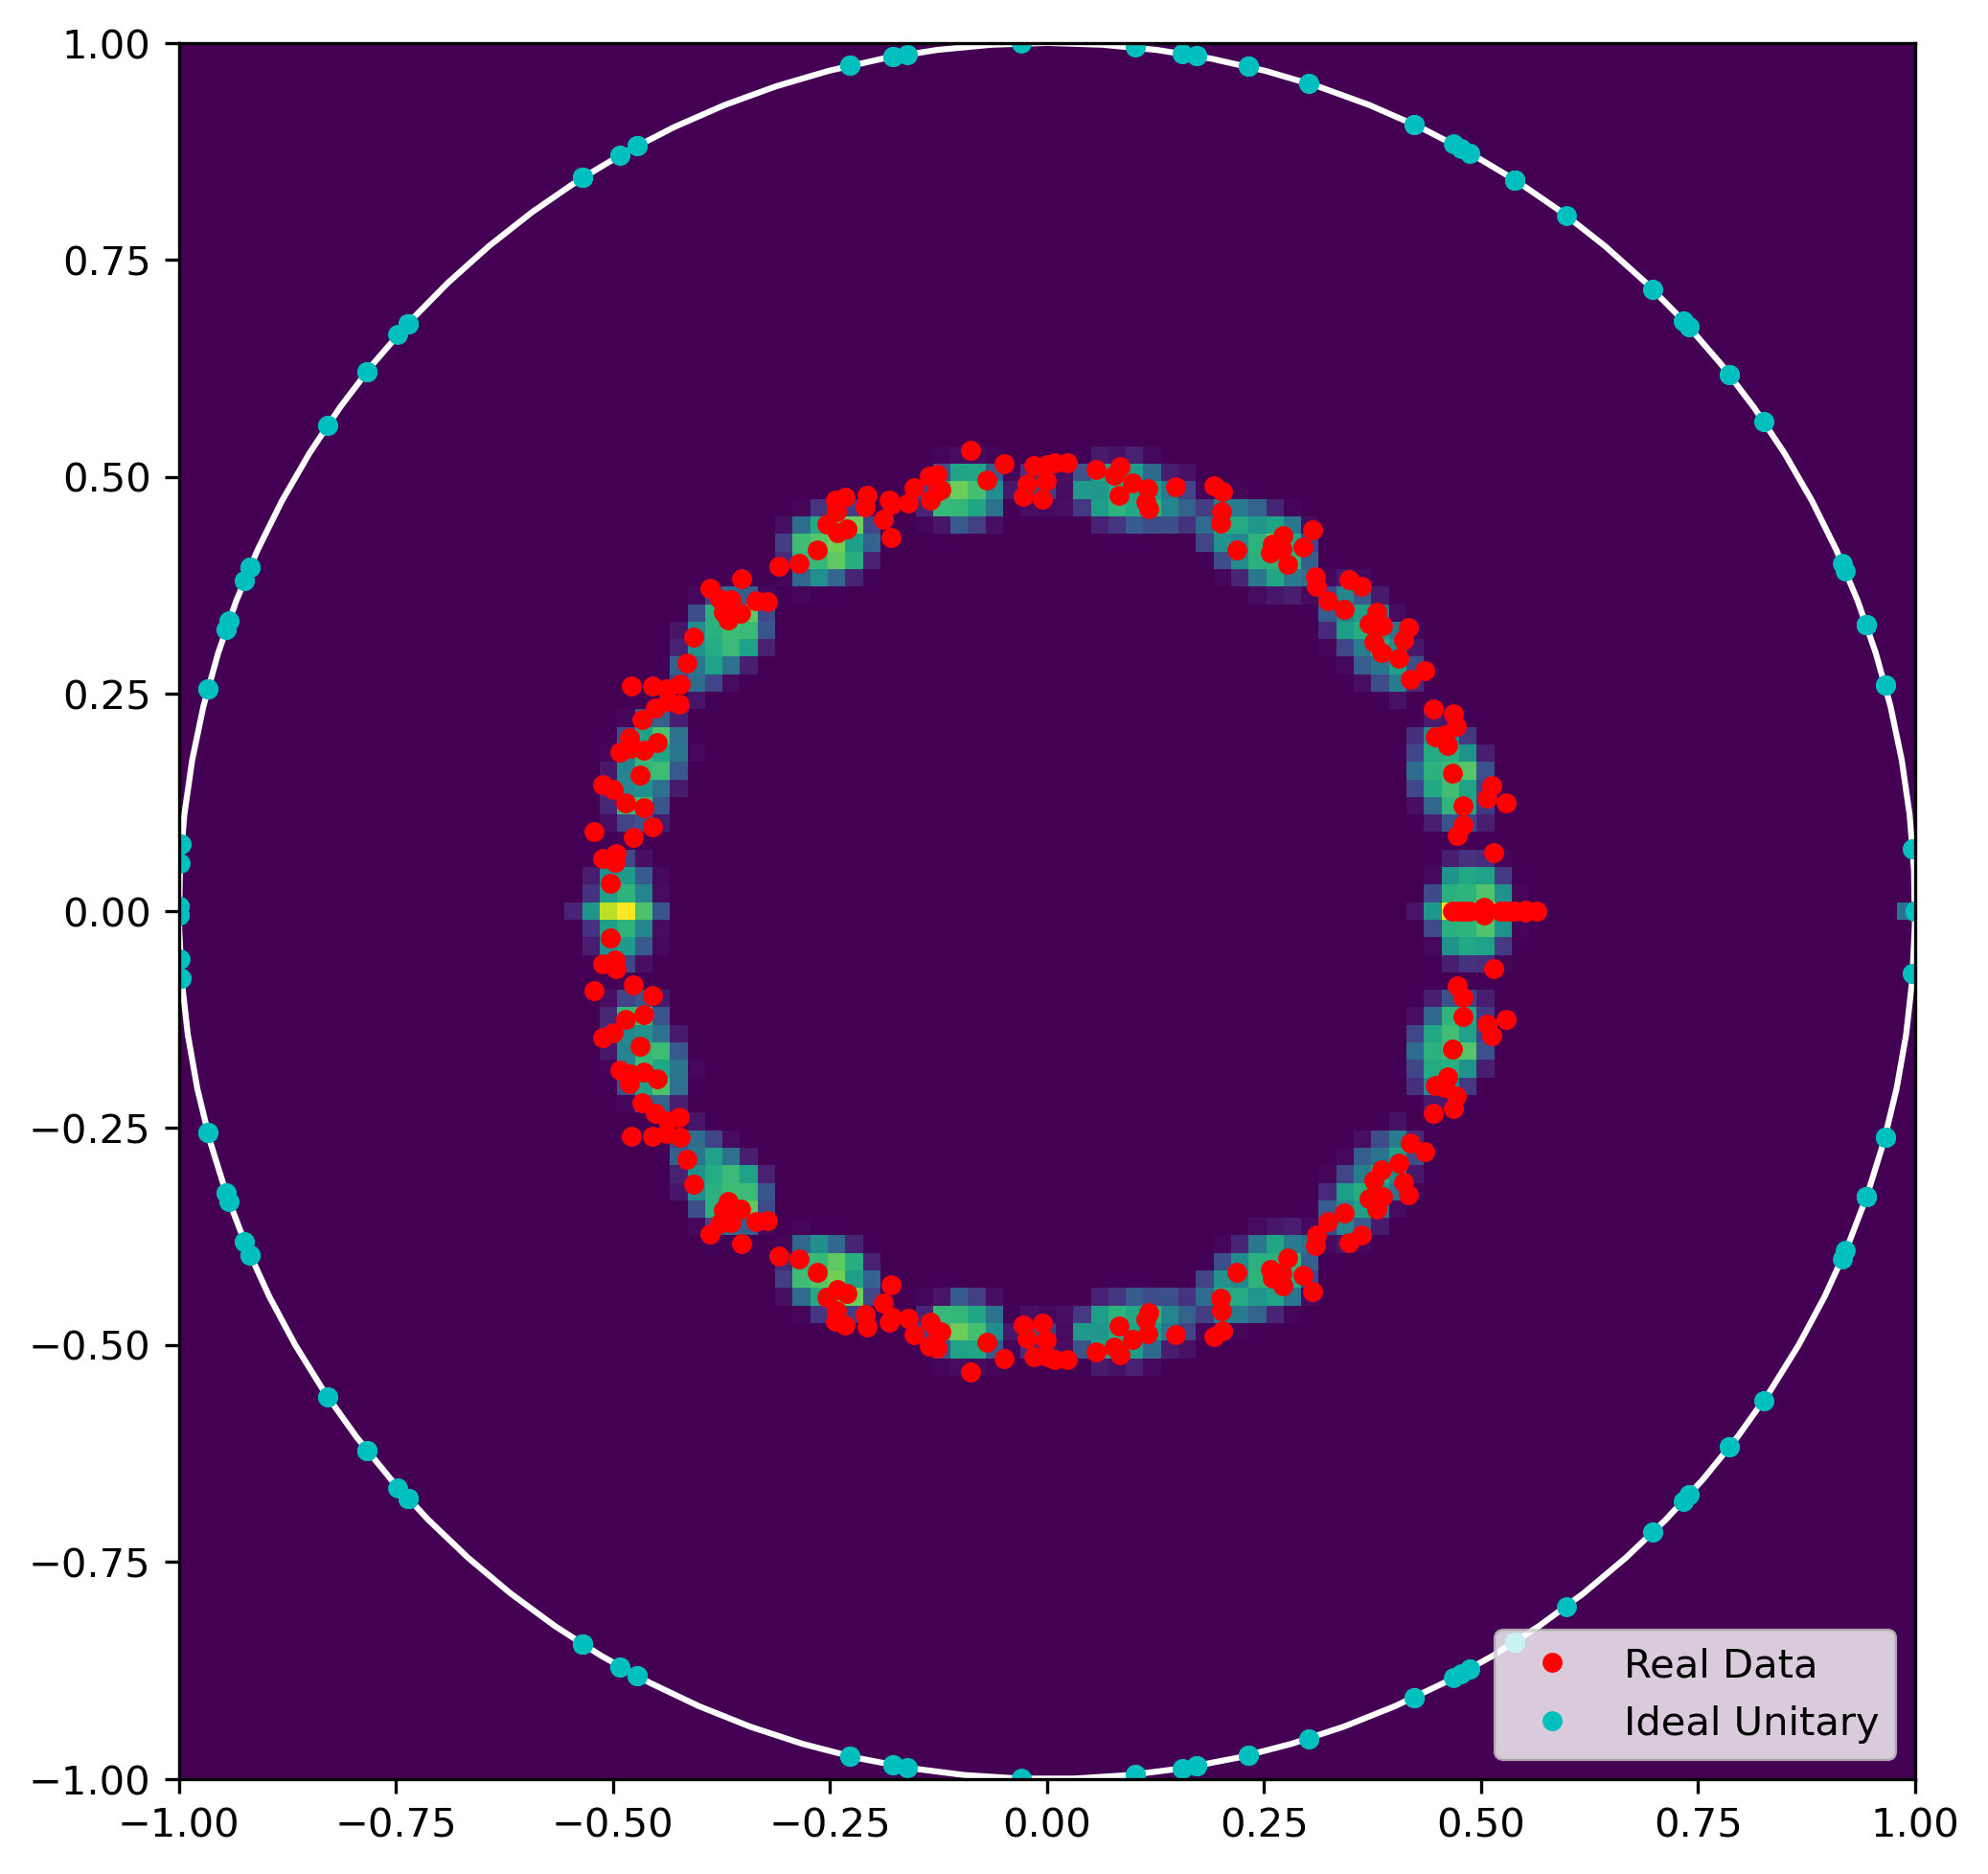

In [50]:
spectrum_model1 = channel_spectrum(model1.channel, use_coords=True)
spectrum_unitary1 = channel_spectrum(channel_unitary, use_coords=True)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

h, bins, _, _ = plt.hist2d(spectrum_resample1[:,0], spectrum_resample1[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(*circle, "w")
plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "ro", markersize=4)
plt.plot(spectrum_unitary1[:,0], spectrum_unitary1[:,1], "co", markersize=4)

plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")
plt.savefig(image_path("integrateble_circuit.pdf"), bbox_inches='tight')
plt.show()

In [18]:
np.savetxt(data_path("integreble_real_spectrum.txt"),     np.real(spectrum_model1), fmt='%f')
np.savetxt(data_path("integreble_unitary_spectrum.txt"),  np.real(spectrum_unitary1), fmt='%f')
np.savetxt(data_path("diluted_histogram.txt"),            h, fmt='%f')
np.savetxt(data_path("diluted_histogram_bins.txt"),       bins, fmt='%f')

In [18]:
np.savetxt(data_path("integrable_resampled_dilutedModel.txt"),  spectrum_resample1, fmt='%f')

## Non-Integrable

In [7]:
model2 = loader(data_path("manila_4qubit_nonintegrable_alternative.model"))
d = model2.channel.d

np.random.seed(42)
random.seed(42)

circuit = nonintegrable_circuit(4, 4)
U = circuit_to_matrix(circuit)

channel_unitary = ChoiMapStatic(U, mode="unitary")
channel_diluted = DilutedKrausMap(U=U, c=0.4, kraus_part=KrausMap(d, rank=12))

In [8]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample2 = resample_diluted(channel_diluted, U=U, num_samples = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\krist\AppData\Local\Temp\ipykernel_6712\1833139310.py:16: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001D8C329E680> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")


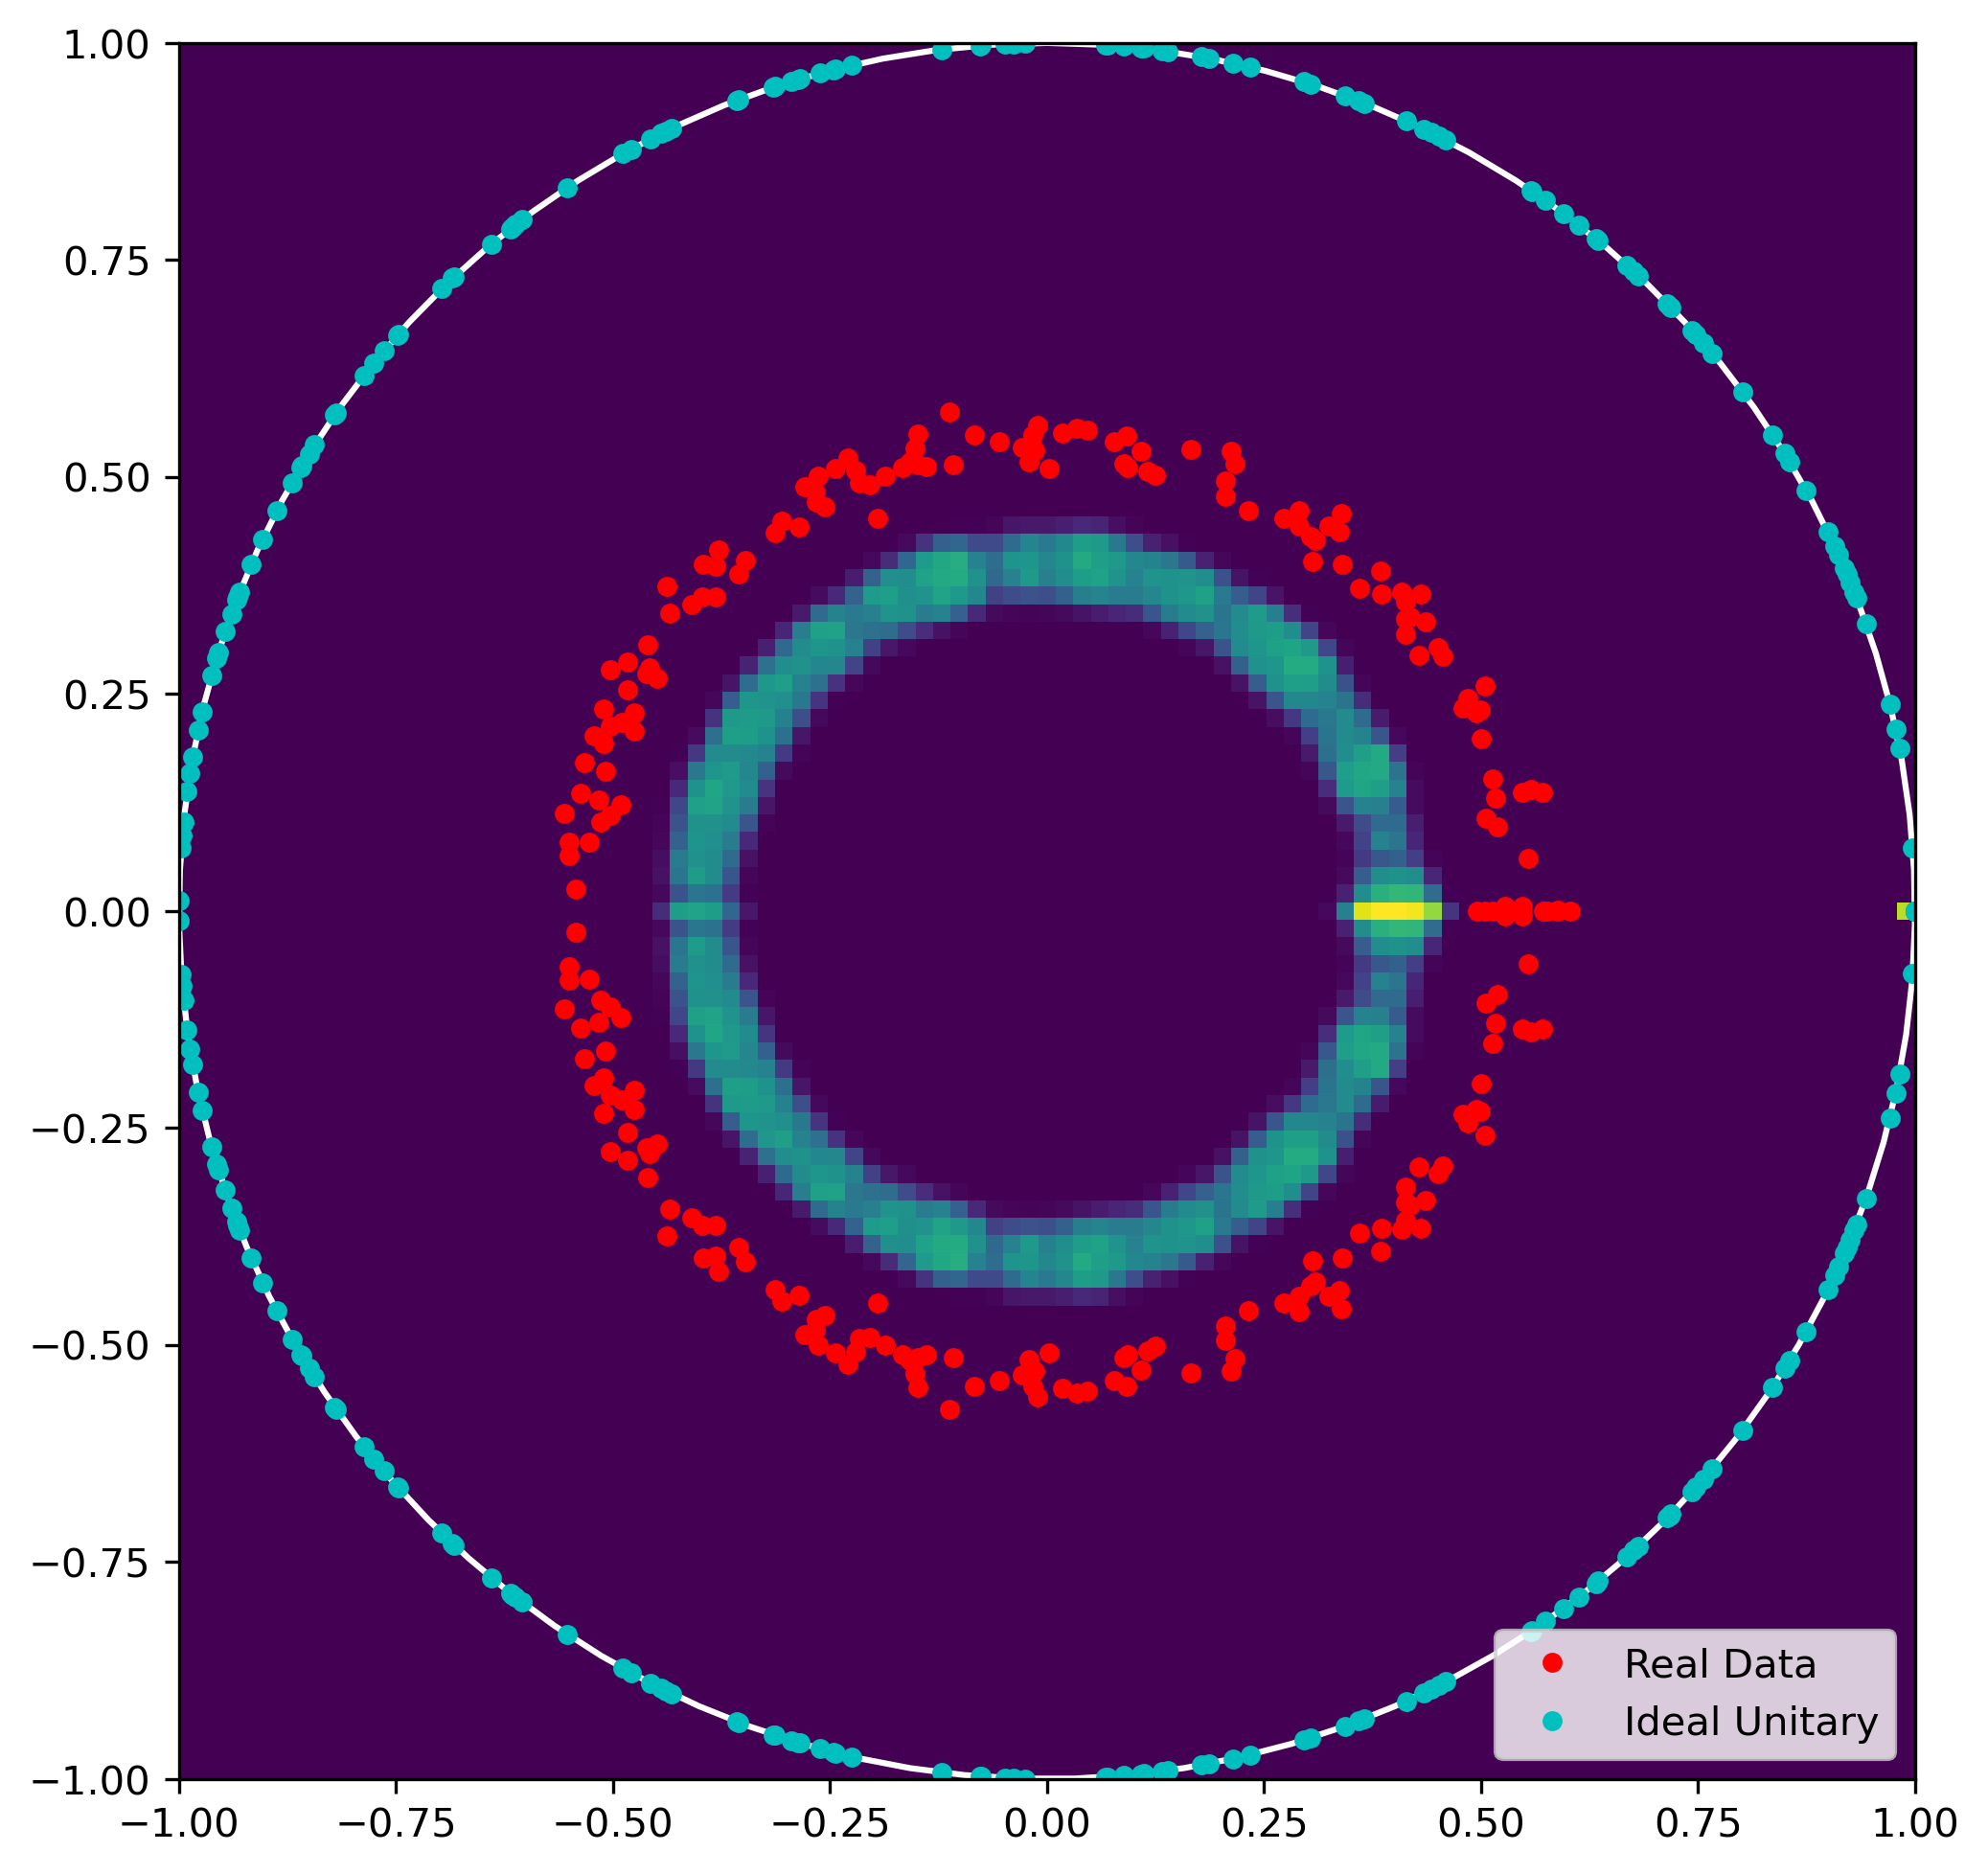

In [10]:
spectrum_model2 = channel_spectrum(model2.channel, use_coords=True)
spectrum_unitary2 = channel_spectrum(channel_unitary, use_coords=True)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

h2, bins2, _, _ = plt.hist2d(spectrum_resample2[:,0], spectrum_resample2[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(*circle, "w")
plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "ro", markersize=4)
plt.plot(spectrum_unitary2[:,0], spectrum_unitary2[:,1], "co", markersize=4)

plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")
plt.savefig(image_path("nonintegrateble_circuit.pdf"), bbox_inches='tight')
plt.show()

In [24]:
np.savetxt(data_path("nonintegrable_real_spectrum.txt"),     np.real(spectrum_model2), fmt='%f')
np.savetxt(data_path("nonintegrable_unitary_spectrum.txt"),  np.real(spectrum_unitary2), fmt='%f')
np.savetxt(data_path("nonintegrable_diluted_histogram.txt"),            h2, fmt='%f')
np.savetxt(data_path("nonintegrable_diluted_histogram_bins.txt"),       bins2, fmt='%f')

In [25]:
spectrum_resample2.shape

(256000, 2)

In [26]:
np.savetxt(data_path("nonintegrable_resampled_dilutedModel.txt"),  spectrum_resample2, fmt='%f')

In [4]:
model3 = loader(data_path("belem_clifford_4qubit.model"))
d = model3.channel.d

np.random.seed(42)
random.seed(42)

circuit = nonintegrabel_circuit(4, 4)
U = circuit_to_matrix(circuit)

channel_unitary = ChoiMapStatic(U, mode="unitary")
channel_diluted = DilutedKrausMap(U=U, c=0.4, kraus_part=KrausMap(d, rank=12))

c:\Program Files\Anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\krisw\AppData\Local\Temp\ipykernel_11028\120863585.py:16: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x0000026D65061540> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")


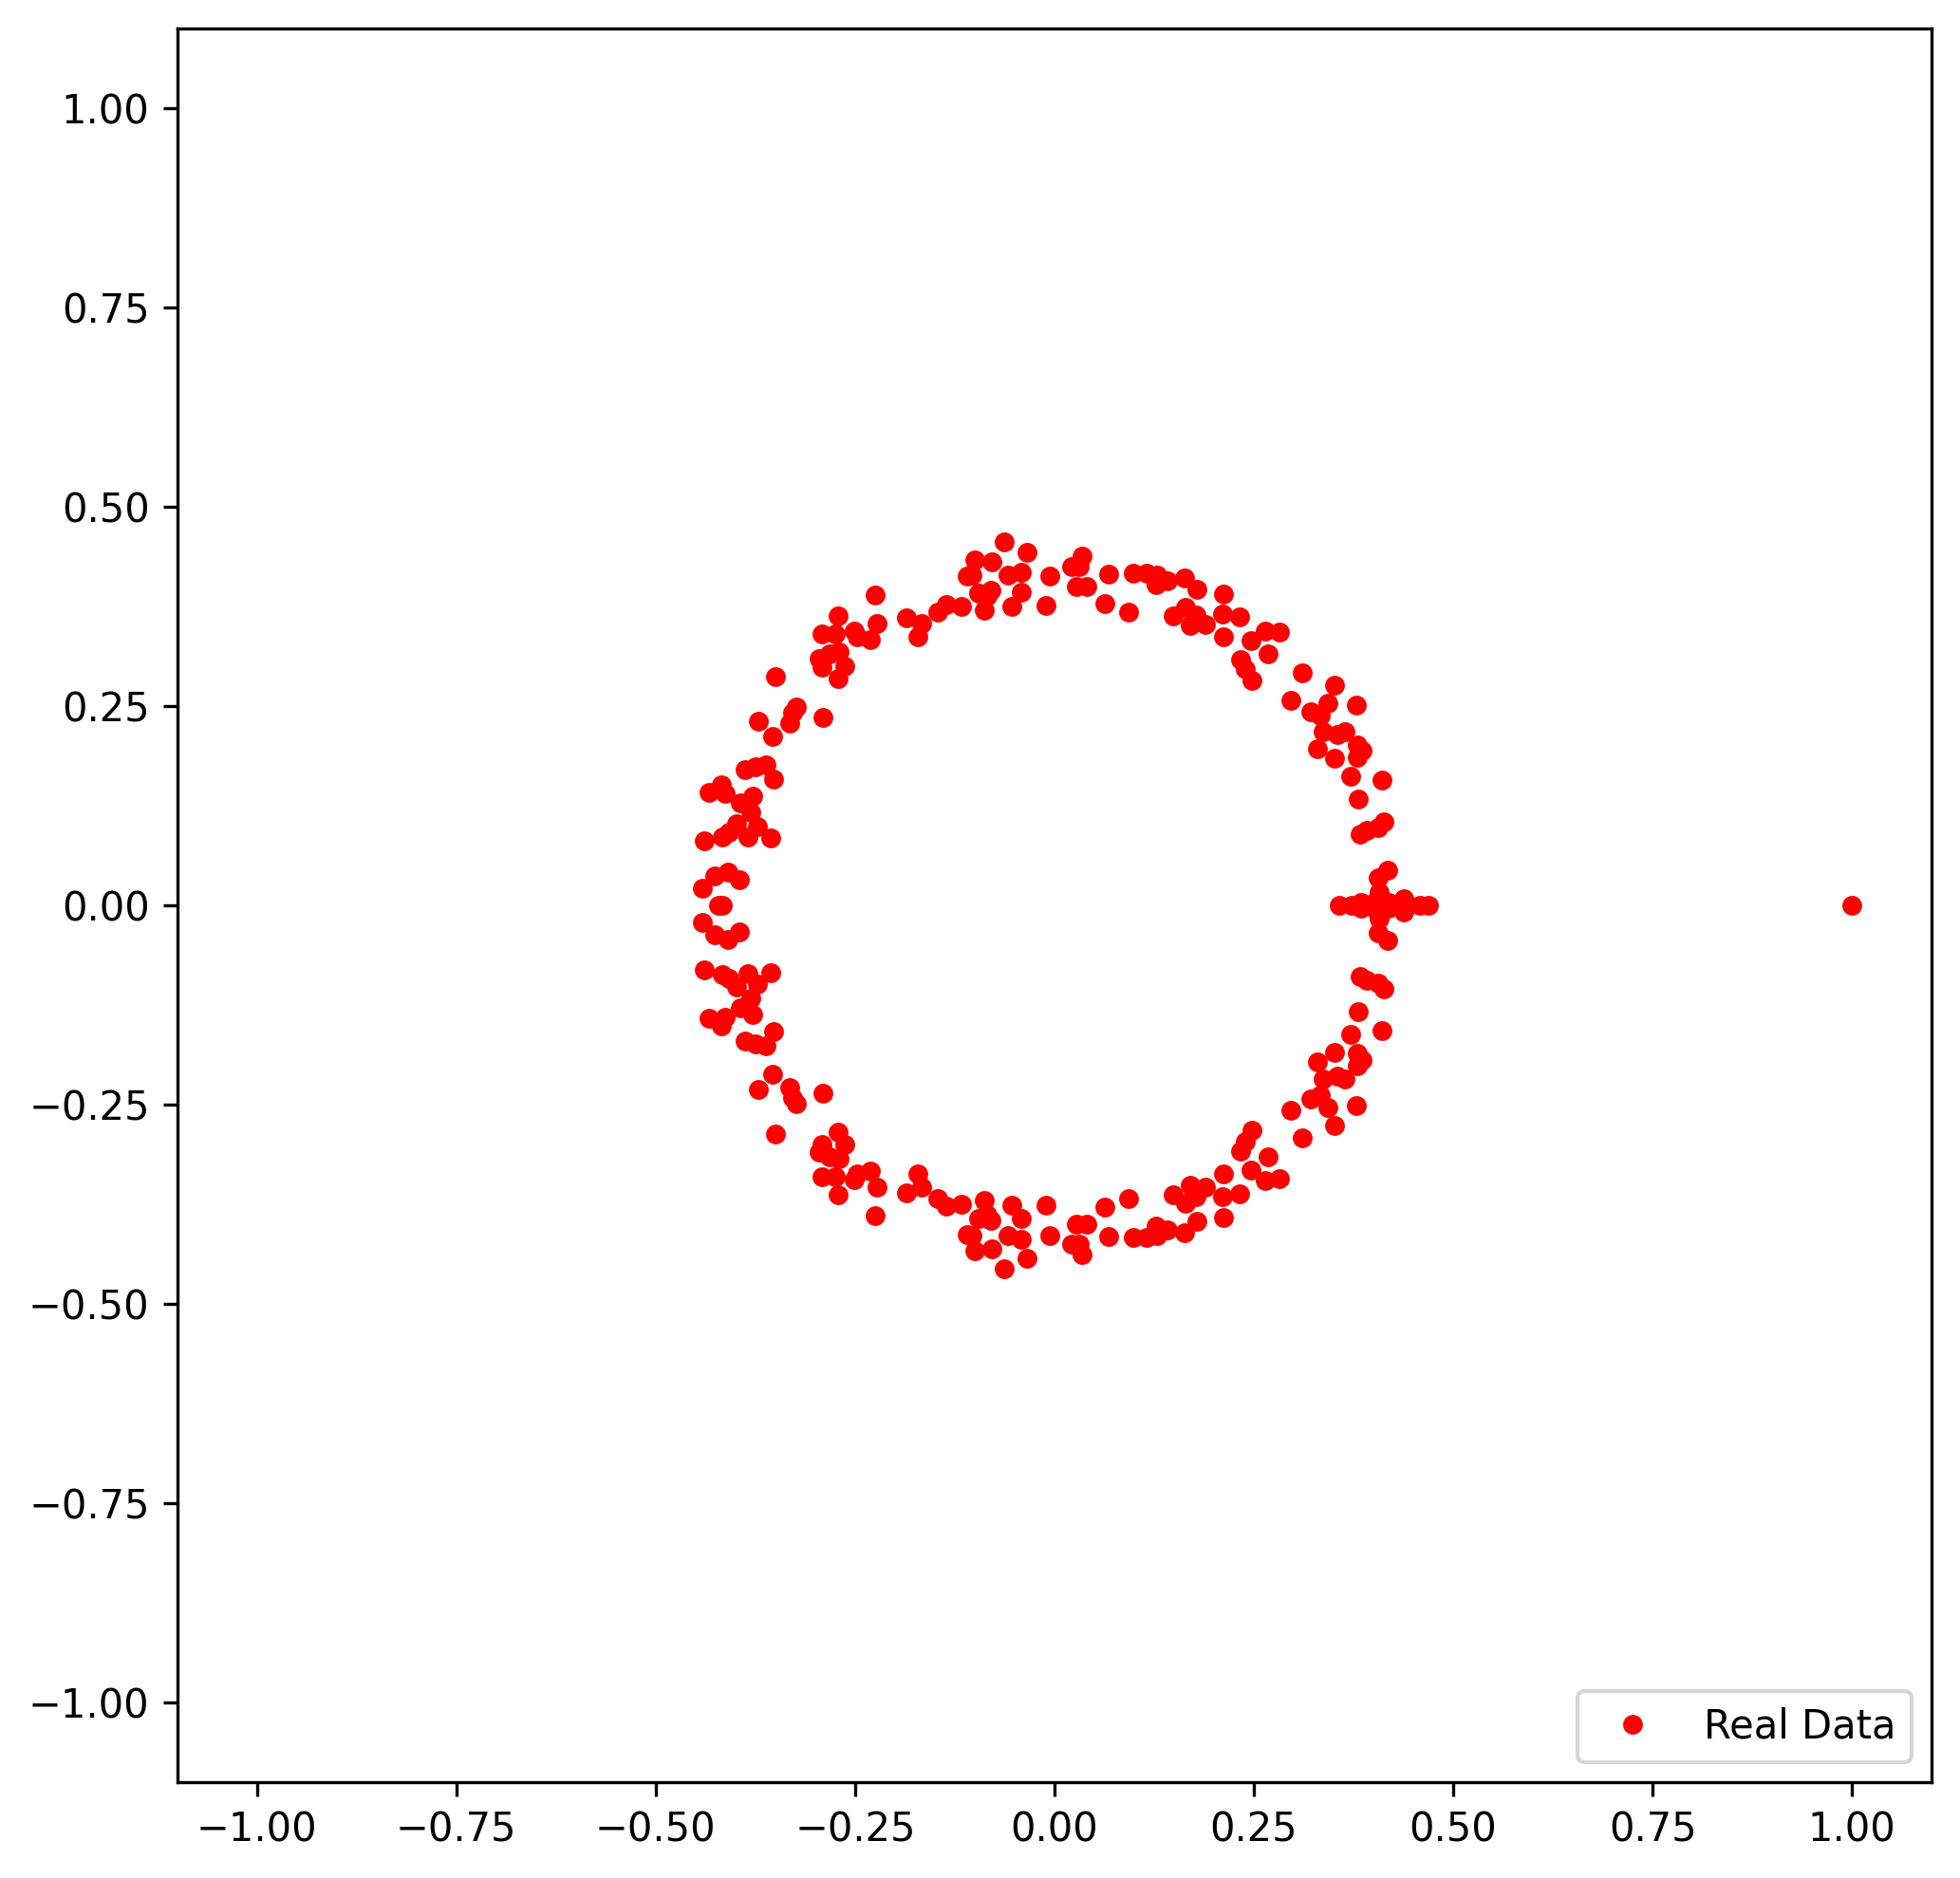

In [5]:
spectrum_model3 = channel_spectrum(model3.channel, use_coords=True)
#spectrum_unitary2 = channel_spectrum(channel_unitary, use_coords=True)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

#plt.hist2d(spectrum_resample2[:,0], spectrum_resample2[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(*circle, "w")
plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "ro", markersize=4)
#plt.plot(spectrum_unitary2[:,0], spectrum_unitary2[:,1], "co", markersize=4)

plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")
#plt.savefig(image_path("nonintegrateble_circuit.pdf"), bbox_inches='tight')
plt.show()